In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from scipy.io import loadmat
import numpy as np
import re
from xml.etree import ElementTree as ET
from matplotlib.path import Path


### We mask the inshore upwelling

In [3]:
## Functions
## kml to struct
def kml2struct(kml_file):
    """
    Import a .kml file as a list of dictionary structures with fields:
    Geometry, Name, Description, Lon, Lat, and BoundingBox.
    """
    # Read the KML file
    try:
        with open(kml_file, 'r', encoding='utf-8') as file:
            txt = file.read()
    except Exception as e:
        raise FileNotFoundError(f"Unable to open file {kml_file}: {e}")

    # Regular expression to match Placemark tags
    expr = r"<Placemark.+?>.+?</Placemark>"
    object_strings = re.findall(expr, txt, re.DOTALL)
    
    kml_struct = []

    for obj_str in object_strings:
        # Extract Name
        name_match = re.search(r"<name.*?>(.*?)</name>", obj_str, re.DOTALL)
        name = name_match.group(1).strip() if name_match else "undefined"

        # Extract Description
        desc_match = re.search(r"<description.*?>(.*?)</description>", obj_str, re.DOTALL)
        desc = desc_match.group(1).strip() if desc_match else ""

        # Determine Geometry Type
        geometry = ""
        if "<Point" in obj_str:
            geometry = "Point"
        elif "<LineString" in obj_str:
            geometry = "Line"
        elif "<Polygon" in obj_str:
            geometry = "Polygon"

        # Extract Coordinates
        coord_match = re.search(r"<coordinates.*?>(.*?)</coordinates>", obj_str, re.DOTALL)
        if not coord_match:
            continue  # Skip if no coordinates are found
        coord_str = coord_match.group(1).strip()
        coord_list = np.array([list(map(float, coord.split(','))) for coord in coord_str.split()])

        # Separate Lon, Lat, and handle Polygons
        lon = coord_list[:, 0]
        lat = coord_list[:, 1]
        if geometry == "Polygon":
            # Close the polygon by appending NaN
            lon = np.append(lon, np.nan)
            lat = np.append(lat, np.nan)

        # Create BoundingBox
        bounding_box = [[lon.min(), lat.min()], [lon.max(), lat.max()]]

        # Append to kml_struct
        kml_struct.append({
            "Geometry": geometry,
            "Name": name,
            "Description": desc,
            "Lon": lon,
            "Lat": lat,
            "BoundingBox": bounding_box
        })

    return kml_struct

In [4]:
# Load the KML file to get the polygon boundary
arch_kml_zona1 = "../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/BK150km.kml"
R1 = kml2struct(arch_kml_zona1)

# Extract Lon and Lat from the first polygon
lonb1 = R1[0]["Lon"]
latb1 = R1[0]["Lat"]

## Lon and lat for the whole dataset
lat = np.linspace(-33.0, 10.03286, 542).reshape(542, 1)  # Reshape to match eta_rho
lon = np.linspace(-118.9083, -68.90833, 602).reshape(1, 602)  # Reshape to match xi_rho

lats, lons = np.meshgrid(lat.flatten(), lon.flatten(), indexing="ij")

LON=lons
LAT=lats
# Create a path from the polygon coordinates
polygon = Path(np.column_stack((lonb1, latb1)))

# Flatten the LON and LAT to create coordinate pairs
lonlat_points = np.column_stack((LON.ravel(), LAT.ravel()))

# Check which points are inside the polygon
mask = polygon.contains_points(lonlat_points).reshape(LON.shape)

# Convert the mask to NaN for the outshore region
inshore_mask = np.where(mask, 1, np.nan)

### Load the Indices

In [5]:
## Load lat from SST
ds_temp = xr.open_dataset('../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/data/avg_Y1990M01.nc',
                            chunks = {'time':1}).temp.isel(s_rho=-1)
ds_temp.lat_rho.values

array([[-33.      , -33.      , -33.      , ..., -33.      , -33.      ,
        -33.      ],
       [-32.93011 , -32.93011 , -32.93011 , ..., -32.93011 , -32.93011 ,
        -32.93011 ],
       [-32.860165, -32.860165, -32.860165, ..., -32.860165, -32.860165,
        -32.860165],
       ...,
       [  9.868679,   9.868679,   9.868679, ...,   9.868679,   9.868679,
          9.868679],
       [  9.950779,   9.950779,   9.950779, ...,   9.950779,   9.950779,
          9.950779],
       [ 10.032859,  10.032859,  10.032859, ...,  10.032859,  10.032859,
         10.032859]], dtype=float32)

## CUI CROCO

In [6]:
CUI_MAX = xr.open_dataset('../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/CUI_MAX.nc',
                            )
CUI_MAX

<xarray.Dataset> Size: 273kB
Dimensions:   (time: 252, lat: 134)
Coordinates:
  * time      (time) datetime64[ns] 2kB 1990-01-01 1990-02-01 ... 2010-12-01
    quantile  float64 8B ...
  * lat       (lat) float32 536B -15.95 -15.87 -15.79 ... -5.242 -5.159 -5.076
Data variables:
    CUI_max   (time, lat) float64 270kB ...

In [7]:
CUI_old = loadmat("../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/CUI_SST_index.mat")
mean_cui = np.array(CUI_old['CUI_SSTi']).squeeze()
lati = np.array(CUI_old['lati']).squeeze()
#print(lati)
print(mean_cui.shape)


(185, 252)


In [8]:
# Convert `CUI_old` data into a DataArray
CUI_old_ts = xr.DataArray(
    data=mean_cui.T,  # numpy array of Mean_CUI
    dims=["time",'lat'],  # Dimension matches the time in CUI_MAX
    coords={"time": CUI_MAX["time"].values,
           'lat': lati},  # Ensure matching time coordinates
    name="CUI_old"  # Name for the variable
)

# # Add `CUI_old` as a new variable to the dataset
CUI_MAX['CUI_old']=CUI_old_ts.where((CUI_old_ts.lat >= -16) & (CUI_old_ts.lat<-5),drop=True)
CUI_MAX

<xarray.Dataset> Size: 543kB
Dimensions:   (time: 252, lat: 134)
Coordinates:
  * time      (time) datetime64[ns] 2kB 1990-01-01 1990-02-01 ... 2010-12-01
    quantile  float64 8B ...
  * lat       (lat) float64 1kB -15.95 -15.87 -15.79 ... -5.242 -5.159 -5.076
Data variables:
    CUI_max   (time, lat) float64 270kB ...
    CUI_old   (time, lat) float64 270kB 0.4255 0.489 0.3985 ... 0.9483 0.6926

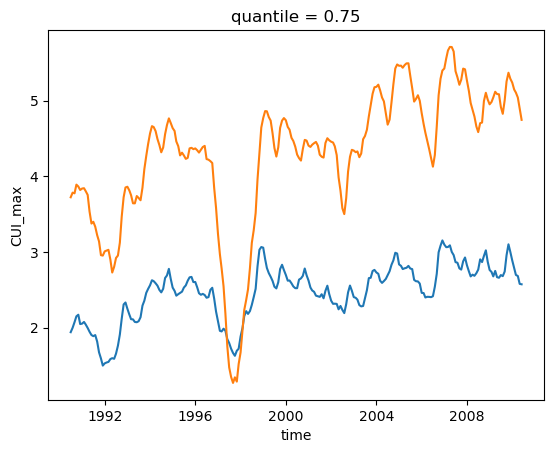

In [64]:
CUI_MAX.CUI_old.mean(dim='lat', skipna=True).rolling(time=13,center=True).mean().plot()
CUI_MAX.CUI_max.mean(dim='lat', skipna=True).rolling(time=13,center=True).mean().plot()

## CUI OSTIA satellite

In [10]:
CUI_satellite = xr.open_dataset('../../NHCS/OSTIA/CUI_satellite.nc',
                            )
CUI_satellite['time'] = CUI_MAX.time
CUI_satellite

<xarray.Dataset> Size: 892kB
Dimensions:   (lat: 220, time: 252)
Coordinates:
  * lat       (lat) float32 880B -15.98 -15.93 -15.88 ... -5.125 -5.075 -5.025
  * time      (time) datetime64[ns] 2kB 1990-01-01 1990-02-01 ... 2010-12-01
    month     (time) int64 2kB ...
    quantile  float64 8B ...
Data variables:
    CUI_max   (time, lat) float64 444kB ...
    CUI_old   (time, lat) float64 444kB ...

## Ekman Pump

In [11]:
## EKMAN
Ekman_data = loadmat("../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/EKMAN_pump_April.mat")
Ek_pump = Ekman_data['EK_pump']
#V_wind = Ekman_data['VEK']
Ek_pump.shape #lon, lat, time

(602, 542, 252)

In [12]:

EK_t=Ek_pump.transpose(2, 1, 0)

latt=ds_temp.lat_rho.values[:,0]
latt.shape

(542,)

In [13]:
EK_ds = xr.Dataset(
    data_vars={
        'Ekman_pump': (("time", "lat","lon"), Ek_pump.transpose(2, 1, 0)),
    },
    coords = {
        'lat':latt,
        'lon':lon.flatten(),
        'time':CUI_MAX.time
}
)

EK_ds

<xarray.Dataset> Size: 658MB
Dimensions:     (time: 252, lat: 542, lon: 602)
Coordinates:
  * time        (time) datetime64[ns] 2kB 1990-01-01 1990-02-01 ... 2010-12-01
    quantile    float64 8B ...
  * lat         (lat) float32 2kB -33.0 -32.93 -32.86 ... 9.869 9.951 10.03
  * lon         (lon) float64 5kB -118.9 -118.8 -118.7 ... -69.07 -68.99 -68.91
Data variables:
    Ekman_pump  (time, lat, lon) float64 658MB -9.628e-07 -1.056e-06 ... nan nan

In [14]:
## get the mask of the EKman pump
Pump_inshore = EK_ds['Ekman_pump'] * inshore_mask
#Pump_inshore.sel(time='1990-01-01').plot()

In [15]:
#Pump_inshore.where((Pump_inshore.lat >= -16) & (Pump_inshore.lat<-5),drop=True)
Pump_inshore=Pump_inshore.where((Pump_inshore.lat >= -16) & (Pump_inshore.lat <= -5) & 
                  (Pump_inshore.lon >= -90) & (Pump_inshore.lon <= -65), drop=True)
Pump_inshore

<xarray.DataArray 'Ekman_pump' (time: 252, lat: 134, lon: 254)> Size: 69MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time      (time) datetime64[ns] 2kB 1990-01-01 1990-02-01 ... 2010-12-01
    quantile  float64 8B 0.75
  * lat       (lat) float32 536B -15.95 -15.87 -15.79 ... -5.242 -5.159 -5.076
  * lon       (lon) float64 2kB -89.96 -89.87 -89.79 ... -69.07 -68.99 -68.91

## Chlorophyll-a

In [16]:
ds_chl = xr.open_dataset('../../NHCS/CHL/cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_CHL_89.98W-65.02W_15.98S-5.02S_1997-09-04-2010-12-31.nc',
                            chunks = {'time':1})
ds_chl

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 4867, latitude: 264, longitude: 600)
Coordinates:
  * latitude   (latitude) float32 1kB -15.98 -15.94 -15.9 ... -5.063 -5.021
  * longitude  (longitude) float32 2kB -89.98 -89.94 -89.9 ... -65.06 -65.02
  * time       (time) datetime64[ns] 39kB 1997-09-04 1997-09-05 ... 2010-12-31
Data variables:
    CHL        (time, latitude, longitude) float32 3GB dask.array<chunksize=(1, 264, 600), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0
    copernicusmarine_version:        1.3.5

In [17]:
# CUI_old = CUI_old.rename({'latitude':'lat'})
ds_chl = ds_chl.rename({'latitude':'lat','longitude':'lon'})
ds_chl

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 4867, lat: 264, lon: 600)
Coordinates:
  * lat      (lat) float32 1kB -15.98 -15.94 -15.9 ... -5.104 -5.063 -5.021
  * lon      (lon) float32 2kB -89.98 -89.94 -89.9 ... -65.1 -65.06 -65.02
  * time     (time) datetime64[ns] 39kB 1997-09-04 1997-09-05 ... 2010-12-31
Data variables:
    CHL      (time, lat, lon) float32 3GB dask.array<chunksize=(1, 264, 600), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0
    copernicusmarine_version:        1.3.5

In [19]:
#mask CHL
## Lon and lat for the whole dataset
lat = ds_chl.lat.values  # Reshape to match eta_rho
lon = ds_chl.lon.values  # Reshape to match xi_rho

LON, LAT = np.meshgrid(lon, lat)

# Create a path from the polygon coordinates
polygon = Path(np.column_stack((lonb1, latb1)))

# Flatten the LON and LAT to create coordinate pairs
lonlat_points = np.column_stack((LON.ravel(), LAT.ravel()))

# Check which points are inside the polygon
mask_chl = polygon.contains_points(lonlat_points).reshape(LON.shape)

# Convert the mask to NaN for the outshore region
inshore_mask_chl = np.where(mask_chl, 1, np.nan)

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:403: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


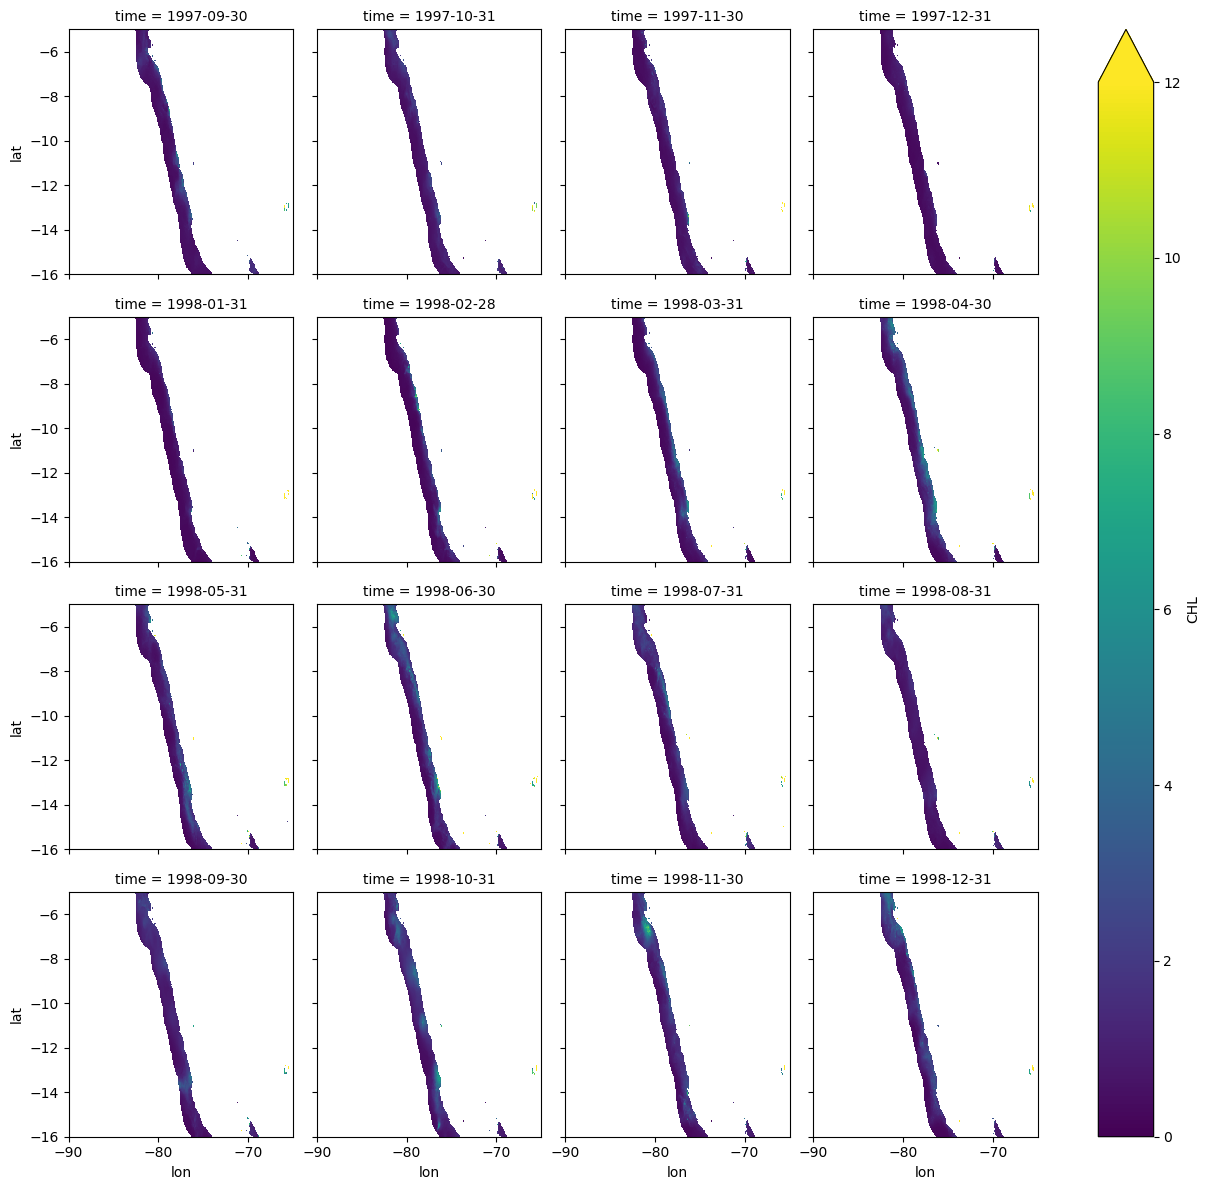

In [65]:
chl = ds_chl * inshore_mask_chl
#monthly average
mm_chl = chl.resample(time="M").mean()
mm_chl.CHL.isel(time=slice(None,16)).plot(x='lon',y='lat',
                                          col='time',col_wrap=4,vmin=0, vmax=12)

CHL = mm_chl.CHL.mean(dim='lon', skipna=True)


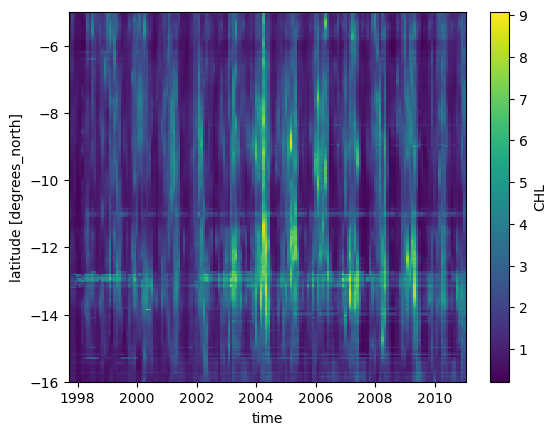

In [66]:
CHL.plot(y='lat')

## Calculate correlations

In [67]:
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

# Rolled Mean
Pumpi = Pump_inshore.mean(dim=('lat','lon'), skipna=True).rolling(time=13,center=True).mean()
CUI_sat_max = CUI_satellite.CUI_max.mean(dim=('lat'), skipna=True).rolling(time=13,center=True).mean()
CUI_sat_old = CUI_satellite.CUI_old.mean(dim=('lat'), skipna=True).rolling(time=13,center=True).mean()
chl_sat = CHL.mean(dim=('lat'), skipna=True).rolling(time=13,center=True).mean()
#Normalize
CUI_old_normal= normalize(CUI_MAX.CUI_old.mean(dim='lat').rolling(time=13,center=True).mean())
CUI_max_normal = normalize(CUI_MAX.CUI_max.mean(dim='lat').rolling(time=13,center=True).mean())
Pump_normal = normalize(Pumpi)
CUI_sat_max_normal = normalize(CUI_sat_max)
CUI_sat_old_normal = normalize(CUI_sat_old)
chl_sat_normal = normalize(chl_sat)

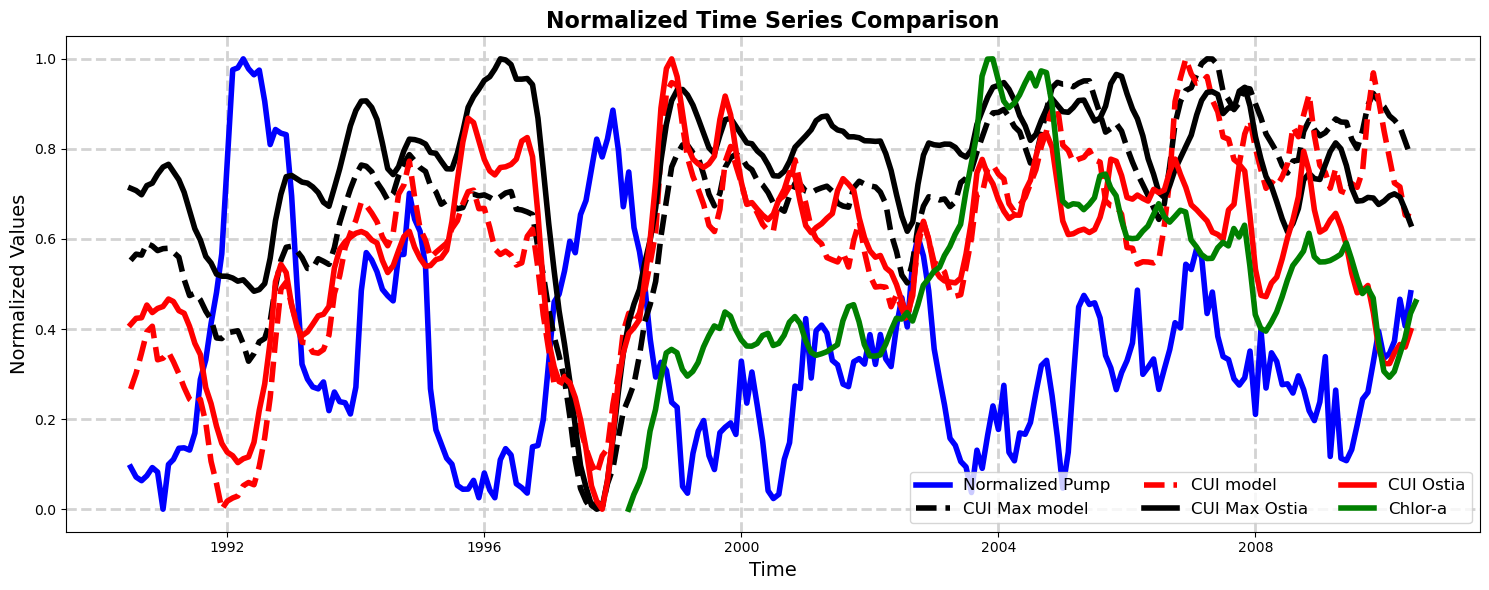

In [68]:
# Plot the normalized data with improved aesthetics
plt.figure(figsize=(15, 6))

# Plot each normalized variable with distinct colors and line styles
Pump_normal.plot(color="blue", linewidth=4, label="Normalized Pump")
CUI_max_normal.plot(color="black", linewidth=4, linestyle='--' , label="CUI Max model")
CUI_old_normal.plot(color="red", linewidth=4, linestyle='--' , label="CUI model")
CUI_sat_max_normal.plot(color="black", linewidth=4, linestyle='-' , label="CUI Max Ostia")
CUI_sat_old_normal.plot(color="red", linewidth=4, linestyle='-' , label="CUI Ostia")
chl_sat_normal.plot(color='green', linewidth=4, linestyle='-' , label="Chlor-a")

# Add title, labels, grid, and legend
plt.title("Normalized Time Series Comparison", fontsize=16, fontweight="bold")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Normalized Values", fontsize=14)
plt.grid(color="lightgrey", linestyle="--", linewidth=2, alpha=1)
plt.legend(fontsize=12, loc="lower right", title_fontsize=12, ncol=3, frameon=True)

# Tight layout for better spacing
plt.tight_layout()

# plt.savefig('../../NHCS/OSTIA/CUI_PUMP_compare_chl.png',format='png', 
#             dpi=300, transparent=True,bbox_inches='tight')

# Display the plot
plt.show()


In [75]:
#print(xr.corr(CUI_sat_max_normal, Pump_normal, dim="time"))
timeis = Pump_normal.sel(time=slice('1997-09-01',None))
chl_sat_normal['time']=timeis.time.values

<xarray.DataArray ()> Size: 8B
array(-0.29731375)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(0.54050959)
Coordinates:
    quantile  float64 8B 0.75


In [76]:
print(xr.corr(Pump_normal.compute().sel(time=slice('1997-09-01',None)),chl_sat_normal.compute(),dim="time"))
print(xr.corr(CUI_max_normal.compute().sel(time=slice('1997-09-01',None)),chl_sat_normal.compute(),dim="time"))
print(xr.corr(CUI_old_normal.compute().sel(time=slice('1997-09-01',None)),chl_sat_normal.compute(),dim="time"))

print(xr.corr(CUI_sat_max_normal.compute().sel(time=slice('1997-09-01',None)),chl_sat_normal.compute(),dim="time"))
print(xr.corr(CUI_sat_old_normal.compute().sel(time=slice('1997-09-01',None)),chl_sat_normal.compute(),dim="time"))


<xarray.DataArray ()> Size: 8B
array(-0.29731375)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(0.54050959)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(0.25406025)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(0.52050168)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(0.29741104)
Coordinates:
    quantile  float64 8B 0.75


In [36]:
## Now lag both according to the Ekman pump
print(xr.corr(CUI_max_normal, Pump_normal, dim="time"))
print(xr.corr(CUI_old_normal, Pump_normal, dim="time"))

print(xr.corr(CUI_sat_max_normal, Pump_normal, dim="time"))
print(xr.corr(CUI_sat_old_normal, Pump_normal, dim="time"))

<xarray.DataArray ()> Size: 8B
array(-0.47450816)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.41214744)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.58548908)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.60214052)
Coordinates:
    quantile  float64 8B 0.75


In [37]:

lags = range(1, 7)  # 1 to 6 months
corr_lags = []

for lag in lags:
    # # Shift the SST anomalies by 1 month (forward in time)
    ssta_lagged = CUI_max_normal.shift(time=-lag)
    
    # Compute the correlation for the current lag
    corr = xr.corr(ssta_lagged, Pump_normal, dim="time")
    
    # Add a new dimension for the lag
    corr = corr.expand_dims(lag=[lag])
    corr_lags.append(corr)

# Concatenate all correlations along the new "lag" dimension
ssta_ekpump_corr_lags = xr.concat(corr_lags, dim="lag")

ssta_ekpump_corr_lags


<xarray.DataArray (lag: 6)> Size: 48B
array([-0.45992265, -0.44101885, -0.41824757, -0.38525039, -0.34148066,
       -0.29037351])
Coordinates:
  * lag       (lag) int64 48B 1 2 3 4 5 6
    quantile  float64 8B 0.75

In [38]:
lags = range(1, 7)  # 1 to 6 months
corr_lags = []

for lag in lags:
    # # Shift the SST anomalies by 1 month (forward in time)
    ssta_lagged = CUI_old_normal.shift(time=-lag)
    
    # Compute the correlation for the current lag
    corr = xr.corr(ssta_lagged, Pump_normal, dim="time")
    
    # Add a new dimension for the lag
    corr = corr.expand_dims(lag=[lag])
    corr_lags.append(corr)

# Concatenate all correlations along the new "lag" dimension
ssta_ekpump_corr_lags = xr.concat(corr_lags, dim="lag")

ssta_ekpump_corr_lags

<xarray.DataArray (lag: 6)> Size: 48B
array([-0.39887036, -0.3767145 , -0.34833033, -0.30802491, -0.25584778,
       -0.19511203])
Coordinates:
  * lag       (lag) int64 48B 1 2 3 4 5 6
    quantile  float64 8B 0.75

In [39]:
lags = range(1, 7)  # 1 to 6 months
corr_lags = []

for lag in lags:
    # # Shift the SST anomalies by 1 month (forward in time)
    ssta_lagged = CUI_sat_max_normal.shift(time=-lag)
    
    # Compute the correlation for the current lag
    corr = xr.corr(ssta_lagged, Pump_normal, dim="time")
    
    # Add a new dimension for the lag
    corr = corr.expand_dims(lag=[lag])
    corr_lags.append(corr)

# Concatenate all correlations along the new "lag" dimension
ssta_ekpump_corr_lags = xr.concat(corr_lags, dim="lag")

ssta_ekpump_corr_lags

<xarray.DataArray (lag: 6)> Size: 48B
array([-0.55564011, -0.51938057, -0.47485725, -0.42242069, -0.36205789,
       -0.29397956])
Coordinates:
  * lag       (lag) int64 48B 1 2 3 4 5 6
    quantile  float64 8B 0.75

In [86]:
lags = range(1, 7)  # 1 to 6 months
corr_lags = []

for lag in lags:
    # # Shift the SST anomalies by 1 month (forward in time)
    ssta_lagged = CUI_sat_old_normal.shift(time=-lag)
    
    # Compute the correlation for the current lag
    corr = xr.corr(ssta_lagged, Pump_normal, dim="time")
    
    # Add a new dimension for the lag
    corr = corr.expand_dims(lag=[lag])
    corr_lags.append(corr)

# Concatenate all correlations along the new "lag" dimension
ssta_ekpump_corr_lags = xr.concat(corr_lags, dim="lag")

ssta_ekpump_corr_lags

<xarray.DataArray (lag: 6)> Size: 48B
array([-0.57192439, -0.52893331, -0.46976261, -0.3977545 , -0.31679902,
       -0.22998418])
Coordinates:
  * lag       (lag) int64 48B 1 2 3 4 5 6
    quantile  float64 8B 0.75

In [86]:
#Pump vs Chlorophyll
Pumps = Pump_normal.compute().sel(time=slice('1997-09-01',None))
                                  
lags = range(1, 7)  # 1 to 6 months
corr_lags = []

for lag in lags:
    # # Shift the SST anomalies by 1 month (forward in time)
    ssta_lagged = chl_sat_normal.compute().shift(time=-lag)
    
    # Compute the correlation for the current lag
    corr = xr.corr(ssta_lagged, Pumps, dim="time")
    
    # Add a new dimension for the lag
    corr = corr.expand_dims(lag=[lag])
    corr_lags.append(corr)

# Concatenate all correlations along the new "lag" dimension
ssta_ekpump_corr_lags = xr.concat(corr_lags, dim="lag")

ssta_ekpump_corr_lags

<xarray.DataArray (lag: 6)> Size: 48B
array([-0.33475488, -0.36569972, -0.37210019, -0.37179237, -0.36811013,
       -0.35692871])
Coordinates:
  * lag       (lag) int64 48B 1 2 3 4 5 6
    quantile  float64 8B 0.75

In [87]:
## CUI max vs chlorophyll
Pumps = CUI_max_normal.compute().sel(time=slice('1997-09-01',None))
                                  
lags = range(1, 7)  # 1 to 6 months
corr_lags = []

for lag in lags:
    # # Shift the SST anomalies by 1 month (forward in time)
    ssta_lagged = chl_sat_normal.compute().shift(time=-lag)
    
    # Compute the correlation for the current lag
    corr = xr.corr(ssta_lagged, Pumps, dim="time")
    
    # Add a new dimension for the lag
    corr = corr.expand_dims(lag=[lag])
    corr_lags.append(corr)

# Concatenate all correlations along the new "lag" dimension
ssta_ekpump_corr_lags = xr.concat(corr_lags, dim="lag")

ssta_ekpump_corr_lags

<xarray.DataArray (lag: 6)> Size: 48B
array([0.51735212, 0.50726466, 0.50753594, 0.51196567, 0.51303099,
       0.50948071])
Coordinates:
  * lag       (lag) int64 48B 1 2 3 4 5 6
    quantile  float64 8B 0.75

### Latitudinal correlation

In [40]:
Pumpi_lat = Pump_inshore.mean(dim=('time','lon')).rolling(lat=13,center=True).mean()
CUI_oldi_lat= CUI_MAX.CUI_old.mean(dim='time').rolling(lat=13,center=True).mean()
CUI_maxi_lat = CUI_MAX.CUI_max.mean(dim='time').rolling(lat=13,center=True).mean()
CUI_sat_oldi_lat= CUI_satellite.CUI_old.mean(dim='time').rolling(lat=13,center=True).mean()
CUI_sat_maxi_lat = CUI_satellite.CUI_max.mean(dim='time').rolling(lat=13,center=True).mean()
chl_sat_lat = CHL.mean(dim='time').rolling(lat=13,center=True).mean()


Pump_normal_la = normalize(Pumpi_lat)
CUI_max_normal_la = normalize(CUI_maxi_lat)
CUI_old_normal_la = normalize(CUI_oldi_lat)
CUI_sat_max_normal_la = normalize(CUI_sat_maxi_lat)
CUI_sat_old_normal_la = normalize(CUI_sat_oldi_lat)
chl_sat_normal_la = normalize(chl_sat_lat)

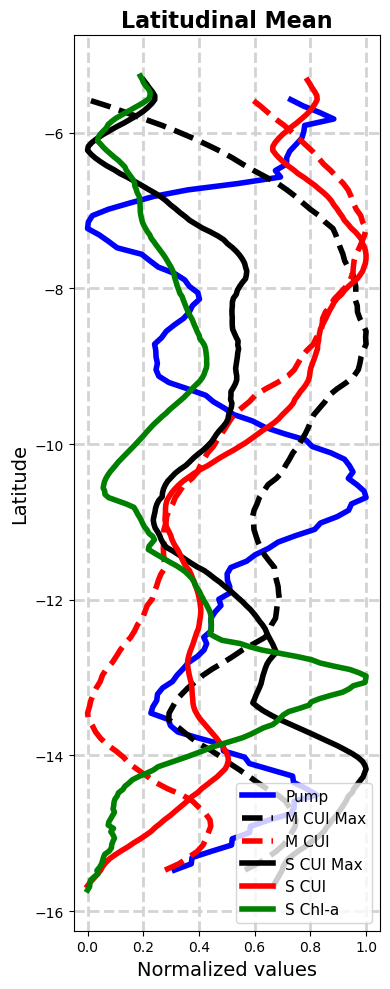

In [43]:
# Plot the normalized data with improved aesthetics
plt.figure(figsize=(4, 10))

# Plot each normalized variable with distinct colors and line styles
Pump_normal_la.plot(y='lat',color="blue", linewidth=4, label="Pump")
#%------- model
CUI_max_normal_la.plot(y='lat',color="black", linewidth=4, linestyle='--', label="M CUI Max")
CUI_old_normal_la.plot(y='lat',color="red", linewidth=4, linestyle='--', label="M CUI")
#%------- satellite
CUI_sat_max_normal_la.plot(y='lat',color="black", linewidth=4, linestyle='-',label="S CUI Max")
CUI_sat_old_normal_la.plot(y='lat',color="red", linewidth=4, linestyle='-',label="S CUI")
chl_sat_normal_la.plot(y='lat',color="green", linewidth=4, linestyle='-',label="S Chl-a")

# Add title, labels, grid, and legend
plt.title("Latitudinal Mean", fontsize=16, fontweight="bold")
plt.xlabel("Normalized values", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.grid(color="lightgrey", linestyle="--", linewidth=2, alpha=1)
plt.legend(fontsize=11, loc="lower right", title_fontsize=12, ncol=1, frameon=True)

# Tight layout for better spacing
plt.tight_layout()

plt.savefig('../../NHCS/OSTIA/CUI_PUMP_compare_lat_chl.png',format='png', 
            dpi=300, transparent=True,bbox_inches='tight')

# Display the plot
plt.show()


In [93]:
print(Pump_normal_la.data.shape)
print(CUI_max_normal_la.data.shape)
print(CUI_sat_max_normal_la.data.shape)

(134,)
(134,)
(220,)


In [96]:
# Step 1: Remove NaN values along the latitude dimension
Pump_normal_clean = Pump_normal_la.dropna(dim="lat", how="any")
CUI_max_clean = CUI_max_normal_la.dropna(dim="lat", how="any")
CUI_old_clean = CUI_old_normal_la.dropna(dim="lat", how="any")

CUI_sat_old_clean = CUI_sat_old_normal_la.dropna(dim="lat", how="any")
CUI_sat_max_clean = CUI_sat_max_normal_la.dropna(dim="lat", how="any")

chl_sat_clean = chl_sat_normal_la.dropna(dim="lat", how="any")

# Step 2: Create a new latitude coordinate with 220 points
new_latitude = np.linspace(
    Pump_normal_clean.lat[0],  # Start of the latitude range
    Pump_normal_clean.lat[-1],  # End of the latitude range
    220  # Desired number of latitude points
)

# Step 3: Interpolate along the latitude dimension
Pump_normal_interp = Pump_normal_clean.interp(lat=new_latitude,method='linear')
CUI_max_interp = CUI_max_clean.interp(lat=new_latitude,method='linear')
CUI_old_interp = CUI_old_clean.interp(lat=new_latitude,method='linear')

CUI_sat_old_interp = CUI_sat_old_clean.interp(lat=new_latitude,method='linear')
CUI_sat_max_interp = CUI_sat_max_clean.interp(lat=new_latitude,method='linear')

CHL_sat_interp = chl_sat_clean.interp(lat=new_latitude,method='linear')
# Step 4: Verify shapes
print(Pump_normal_interp.shape)
print(CUI_max_interp.shape)
print(CUI_sat_max_interp.shape)


(220,)
(220,)
(220,)


In [105]:
print(xr.corr(CUI_max_interp, Pump_normal_interp, dim="lat"))
print(xr.corr(CUI_old_interp, Pump_normal_interp, dim="lat"))

print(xr.corr(CUI_sat_max_interp, Pump_normal_interp, dim="lat"))
print(xr.corr(CUI_sat_old_interp , Pump_normal_interp, dim="lat"))


print(xr.corr(Pump_normal_interp, CHL_sat_interp.compute(), dim="lat"))
print(xr.corr(CUI_max_interp , CHL_sat_interp.compute(), dim="lat"))
print(xr.corr(CUI_old_interp, CHL_sat_interp.compute(), dim="lat"))
print(xr.corr(CUI_sat_max_interp , CHL_sat_interp.compute(), dim="lat"))
print(xr.corr(CUI_sat_old_interp, CHL_sat_interp.compute(), dim="lat"))


<xarray.DataArray ()> Size: 8B
array(-0.3508623)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.27044154)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.26779012)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.4337742)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.52278357)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.19082756)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.44343129)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(0.3122583)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.05764341)
Coordinates:
    quantile  float64 8B 0.75


In [81]:
cuimax=CUI_MAX.CUI_max.mean(dim='time').rolling(lat=13,center=True).mean()
cuiold=CUI_MAX.CUI_old.mean(dim='time').rolling(lat=13,center=True).mean()
cuimax
import pandas as pd
# Convert xarray objects to pandas DataFrame
df = pd.DataFrame({
    'CUI_max': cuimax.data,
    'Pump': Pumpi_lat.data
})
#print(*df["CUI_max"])
# # Drop rows with NaN values
df_clean = df.dropna()

# # Compute the correlation
correlation = df_clean['CUI_max'].corr(df_clean['Pump'])
print("Correlation between CUI_max and Pump:", correlation)

df_clean

Correlation between CUI_max and Pump: -0.3462222240439226


,CUI_max,Pump
6,4.246452,0.000011
7,4.284157,0.000011
8,4.314999,0.000011
9,4.342268,0.000011
10,4.363703,0.000011
...,...,...
123,3.991917,0.000013
124,3.936733,0.000013
125,3.881378,0.000013
126,3.825434,0.000013


In [82]:
# # Similarly for the old CUI
df_old = pd.DataFrame({
    'CUI_old': cuiold.data,
    'Pump': Pumpi_lat.data
})

# Drop rows with NaN values
df_old_clean = df_old.dropna()

# # Compute the correlation
correlation = df_old_clean['CUI_old'].corr(df_clean['Pump'])
print("Correlation between CUI_old and Pump:", correlation)


Correlation between CUI_old and Pump: -0.2653133333427118
